# Figure of merit for CAT gratings

In this Jupyter notebook, I show the effective area and resolution we can expect for ARCUS with CAT gratings. 

### What's in this document and what is not
This document contains mostly results of simulations, not the code itself because many of the plots below require a grid of simulations, e.g. in for different energies, and take while to run. Thus, those grids are run in a separate process and the relevant results (e.g. the position of the final rays on the detector) is saved in a fits file. In this notebook we then parse these fits files to extract the relevant information.

### How to read this document
This notebook is a format that displays code, plots and other output on the same html page. You can just looks that the plots (some of them are interactive and allow zoming - look for small icons that appear when you mouse cursor is above it) and my explanatory text.

Use the "toggle on/off raw code" button below to display the code to inspect in detail how the plots are made. Please let me know if you find any error or omissions. The plotting and simulations are done in Python but even if you do not use that language, you can probably see which columns or rows of the fits data files I compare in plots.

## What's included in the simulations?
Details of the setup for the simulations are obviously defined in the python code, but a list of the most important effects that are included is here:

- On-axis, point-like source
- Spacecraft pointing with jitter
- Mirror with in-plane and out-of-plane scatter
- two optical axes, each of them used by one pair of channels
- One rectangular aperture per channel (more details of the SPO size coming later)
- 30 mm * 30 mm grating facets on a rectangular grid with 2 mm wide holdign structures in between
- facets are flat (i.e. simulation includes finite size effects)
- CCDs are flat and have pixels
- CCD gaps between individual chips.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [73]:
import os
import sys
from glob import glob
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import astropy
import astropy.coordinates
from astropy.table import Table, Column
import astropy.units as u

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)


In [3]:
from cycler import cycler

In [4]:
import marxs
from marxs.source import PointSource, FixedPointing
import arcus
import arcus.arcus as instrum

INFO:root:Reading configuration data from ['/nfs/cxc/h2/guenther/.astropy/config/arcus.cfg']
INFO:root:data files in /melkor/d1/guenther/projects/ARCUS/caldb-inputdata: version hash: 7a32fdd - commited on 2017-06-08 17:13:30 -0400

INFO:root:Loading data from spos/petallayout
INFO:root:Loading data from spos/geometricthroughput
INFO:root:Loading data from spos/reflectivity_simple
INFO:root:Loading data from other/pointingjitter
INFO:root:Loading data from gratings/efficiency
INFO:root:Loading data from gratings/debyewaller
INFO:root:Loading data from gratings/debyewaller
INFO:root:Loading data from filters/sifilter
INFO:root:Loading data from filters/opticalblocking
INFO:root:Loading data from filters/uvblocking
INFO:root:Loading data from detectors/contam
INFO:root:Loading data from detectors/qe


In [5]:
import marxs.version
import arcus.version
print('MARXS version {} (commit hash: {} from {})'.format(marxs.version.version, marxs.version.githash, marxs.version.timestamp))
print('ARCUS version {} (commit hash: {} from {})'.format(arcus.version.version, arcus.version.githash, arcus.version.timestamp))

MARXS version 1.1.dev579 (commit hash: e4533d88dd4019510ea51eed6d98f882c27b3f5c from 2017-06-26 10:43:11.132945)
ARCUS version 0.0.dev76 (commit hash: af164568316a02c40b1602831e3e5325d446bea5 from 2017-06-19 16:11:07.210018)


In [6]:
import mpld3
#mpld3.disable_notebook()

In [7]:
datadir = '/melkor/d1/guenther/Dropbox/ARCUS/rays/semi-compact/'
dataroot = '/melkor/d1/guenther/Dropbox/ARCUS/rays/'
figureout = '/melkor/d1/guenther/Dropbox/ARCUS/plots/'

In [8]:
rayfiles = glob(os.path.join(datadir, '*.fits'))
rayfiles.sort()

In [9]:
allrays = [Table.read(f) for f in rayfiles]

In [10]:
r0 = allrays[0]
print 'Files were written with'
print 'MARXS version', r0.meta['MARXSVER']
print 'ARCUS version', r0.meta['ARCUSVER']
print 'ARCUS inpudata git hash', r0.meta['ARCDATHA']

for r in allrays:
    if not ((r0.meta['MARXSVER'] == r.meta['MARXSVER']) and (r0.meta['ARCUSVER'] == r.meta['ARCUSVER']) and 
            (r0.meta['ARCDATHA'] == r.meta['ARCDATHA'])):
        raise Exception('Data inconsistent')

Files were written with
MARXS version 1.1.dev559
ARCUS version 0.0.dev75
ARCUS inpudata git hash 7a32fdd


In [11]:
# Each file is for a single energy
wave = np.array([(t['energy'][0] * u.keV).to(u.Angstrom, equivalencies=u.spectral()).value for t in allrays])

In [12]:
def fractional_aeff(photons, orders, filterfunc=None, col='order'):
    '''Calculate the fraction of photons that are detected in a specific order
    
    While written for calculating Aeff per order, this can be used with any discrete
    quantity, e.g. Aeff per CCD.
    
    Parameters
    ----------
    photons : `astropy.table.Table`
        Photon event list
    orders : np.array
        Orders for w
    filterfunc : callable or ``None``
        If not ``None``, a function that takes the photon table and returns an
        index array. This can be used, e.g. filter out photons that hit particular CCDs or
        hot columns.
    col : string
        Column name for the order column.
        
    Returns
    -------
    prop : np.array
        Probability for a photon in a specific order to be detected.
    '''
    prob = np.zeros_like(orders, dtype=float)
    for i, o in enumerate(orders):
        ind = (photons[col] == o)
        if filterfunc is not None:
            ind = ind & filterfunc(photons)
        prob[i] = np.sum(photons['probability'][ind]) / len(photons)
    return prob

## Effective area

In [13]:
orders = np.arange(-10, 1)
photonfilter = lambda p: np.isfinite(p['probability']) & (p['CCD_ID'] >=0)
aeff = np.array([fractional_aeff(p, orders, filterfunc=photonfilter) for p in allrays])

In [14]:
outtab = Table(aeff, names = ['order_{0}'.format(o) for o in orders])
outtab.add_column(Column(name='wave', data=wave), index=0)
outtab['wave'].unit = u.Angstrom
outtab.write(os.path.join(figureout, 'Aeff.csv'), format='ascii.csv', overwrite=True)

In [15]:
# In principle, the absolute area is an input to the ray-trace and that infomation is already availble
# in the ray files.
# However, I chose to normalize all that to 1 cm^2 and multiply with this factor here, because that makes
# it easier to change the number if I need new plots for an updated design later.
Ageometric = 1428.48 * 2

In [95]:
colorcycle = ['#348ABD', '#7A68A6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33']

def plot_aeff(aeff, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(wave, aeff[:, -1] * Ageometric * 2, 'k:', label='0th order')
    ax.plot(wave, np.sum(aeff[:, :-1], axis=1) * Ageometric * 2, 'k', label='all dispersed\norders')

    for i, c in zip(np.arange(3, 10), colorcycle):
        ax.plot(wave, aeff[:, i] * Ageometric * 2, label='order {0}'.format(orders[i]))
    ax.legend()
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('$A_\mathrm{eff}$ [cm$^2]$')
    temp = ax.set_xlim([8, 55])
    return ax

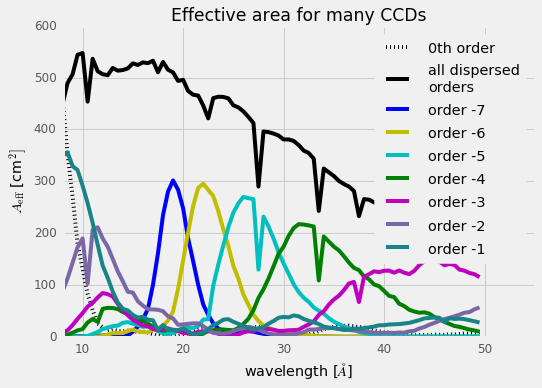

In [106]:
with mpl.style.context('fivethirtyeight'):
    plt.rc('axes', prop_cycle=(cycler('linestyle', ['-', '--', ':']) * 
                           cycler('color', ['r', 'b', 'y', 'c', 'g', 'm', '#7A68A6', '#188487', '#E24A33'])))
    # Do the same plot but split up by energy ranges
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plot_aeff(aeff, ax)
    ax.set_title('Effective area for many CCDs')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85)
    fig.savefig(os.path.join(figureout, 'Aeff_16CCDs.png'))
    fig.savefig(os.path.join(figureout, 'Aeff_16CCDs.pdf'))

Effective area curve for ARCUS setup. This curve assumes that we can place as many CCD detectors as we would like in the focal plane. There are CCD gaps, but the number of CCDs required to catch all possible photons in all orders is too high to be practical. In the next few code cells and plots I explore the trade-offs in selecting only a subset (16) CCDs in the focal plane. Some weak orders will be lost as seen below. First, add up all photons that hit a particular CCDs. This tells us which CCDs out of the large number are receiving the most signal and we will select the 16 CCDs with the largest number of photons as the CCD locations wehre we actually place physical hardware on the spacecraft.

In [18]:
orders = np.arange(-10, 1)
photonfilter = lambda p: np.isfinite(p['probability']) & (p['facet'] < 2000)
photonfilterm = lambda p: np.isfinite(p['probability']) & (p['facet'] >= 2000)

id_ccd = np.arange(0, 90)
n_ccd = np.array([fractional_aeff(p, id_ccd, filterfunc=photonfilter, col='CCD_ID') for p in allrays])
n_ccdm = np.array([fractional_aeff(p, id_ccd, filterfunc=photonfilterm, col='CCD_ID') for p in allrays])

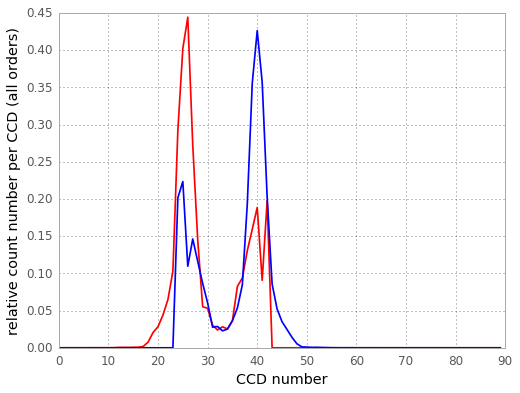

In [19]:
plt.plot(id_ccd, n_ccd.sum(axis=0))
plt.plot(id_ccd, n_ccdm.sum(axis=0))

#plt.xlim([0, 15])
plt.xlabel('CCD number')
plt.ylabel('relative count number per CCD (all orders)')

In a CAT grating, photons are predominatly diffracted into orders that are located at roughly twice the blaze angle. However, other orders also receive some signal. For one configuration of CCD detectors placed on a Rowland Circle, this figure shows the total number of photons that each detector will see (assuming a flat input spectrum). The two lines show the number of photons for different pairs of channels, because each pair of channels has their own optical axis.

For the blue line, the zeroth order is located on CCD 40, most of the diffrected signal is seen in CCDs 20-30.
From this plot, we can determine which are the 16 CCDs that get the most signal and then realize that configuration in the ARCUS hardware.

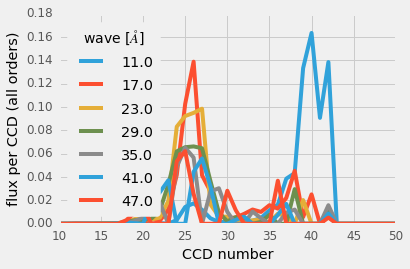

In [97]:
with mpl.style.context('fivethirtyeight'):
    # Do the same plot but split up by energy ranges
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    n = 12
    for i in range(84/n):
        ax.plot(id_ccd, n_ccd[i*n:(i+1)*n:].sum(axis=0), label=wave[i*n+n/2])

    ax.set_xlim([10, 50])
    ax.set_xlabel('CCD number')
    ax.set_ylabel('flux per CCD (all orders)')
    ax.legend(title='wave [$\AA$]')
    fig.subplots_adjust(bottom=0.17, left=0.17, top=.90)
    fig.savefig(os.path.join(figureout, 'fluxperCCD.png'))
    fig.savefig(os.path.join(figureout, 'fluxperCCD.pdf'))

This is a plot looks in a little more details which CCDs are imporant. It takes the blue line in the plot above this one and splits the detected photons up in wavelength bins. Short wavelength are found mostly close to the zeroth order location (around CCD 40), all of the longer wavelengths concentrate on CCDs around 25.

(The red line on the plot above this one could be split up in the same fashing. The result would look very similar, just mirrored.)

In [21]:
# Find the top 16 CCDs by count number
counts_all_channels = np.sum(n_ccd + n_ccdm, axis=0)
topccdids = np.argsort(counts_all_channels)[-16:]
topccdids.sort()
topccdids

array([23, 24, 25, 26, 27, 28, 29, 30, 36, 37, 38, 39, 40, 41, 42, 43])

In [22]:
# Now, shift one of the channels by hand:
# topccdids = np.array([22,23,24,25,26,27,28,29,36,37,38,39,40,41,42,43])

In [23]:
arcus.arcus.det.distribute_elements_on_arc()[topccdids][[0, 7, 8, -1]]

array([ 3.13346625,  3.19172335,  3.241658  ,  3.2999151 ])

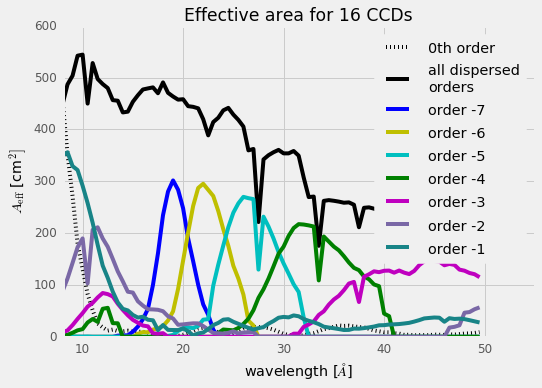

In [141]:
# Idea: Add plot from above (infinite number of CCDs) e.g. in dashed (remove 0th order from plot)
# or with lower opacity
# That would enable an easier comparison

def photonfilter_general(photons, topccdids):
    ind = np.zeros(len(photons), dtype=bool)
    for i in topccdids:
        ind = ind | (photons['CCD_ID'] == i)
    return ind & np.isfinite(photons['probability'])

photonfiltertopccds = functools.partial(photonfilter_general, topccdids=topccdids)

aeff_16ccd = np.array([fractional_aeff(p, orders, filterfunc=photonfiltertopccds) for p in allrays])

with mpl.style.context('fivethirtyeight'):
    plt.rc('axes', prop_cycle=(cycler('linestyle', ['-', '--', ':']) * 
                           cycler('color', ['r', 'b', 'y', 'c', 'g', 'm', '#7A68A6', '#188487', '#E24A33'])))
    # Do the same plot but split up by energy ranges
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plot_aeff(aeff_16ccd, ax)
    ax.set_title('Effective area for 16 CCDs')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85)
    fig.savefig(os.path.join(figureout, 'Aeff_16CCDs.png'))
    fig.savefig(os.path.join(figureout, 'Aeff_16CCDs.pdf'))

In [25]:
outtab = Table(aeff_16ccd, names = ['order_{0}'.format(o) for o in orders])
outtab.add_column(Column(name='wave', data=wave), index=0)
outtab['wave'].unit = u.Angstrom
outtab.write(os.path.join(figureout, 'Aeff_16CCDs.csv'), format='ascii.csv', overwrite=True)

Effective areas assuming that ARCUS contains the 16 CCDs the cover the largest number of photos as determined from the last plot. Steps appear in the total effective area curve, when an order moved beyond the area covered with chips (e.g. order -4 at 38 Ang). Gaps indicate an order that hits a chip gap. In reality there will be more chip gaps, but the limited resolution of the simulations (wavelength grid as 1 Ang wide steps) not all of them are seen here.

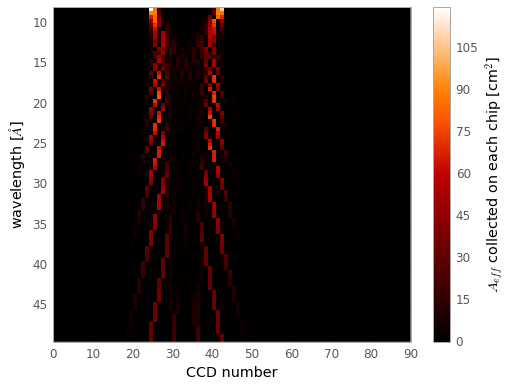

In [26]:
plt.imshow((n_ccd + n_ccdm) * Ageometric, interpolation='none',
          extent=( 0, len(counts_all_channels), wave[-1], wave[0]), aspect='auto')
plt.ylabel('wavelength [$\AA{}$]')
plt.xlabel('CCD number')
colbar = plt.colorbar(label='$A_{eff}$ collected on each chip [cm$^2$]')

This is another way of showing which CCDs are detecting the most signal. As in the plot above, the CCD ID number is shown on the x-axis, but instead of summing the signal over all wavelengths, it's shown here for each wavelength. 
There are two pairs of channels, so everything is mirrored at about CCD ID 32 or so. The figure shows roughly diagonal strips. As the wavelength increases from the top towards the bottom of the plot, a particular grating order gets dispersed to larger angles, causing the strip to move outward. As the order moves away from the preferred angle, it gets wekaer and weaker and more photons are found in the next lower order, which can be seen as a next line appearing. For most wavelength the signal is concentated in one or two orders for each wavelength.

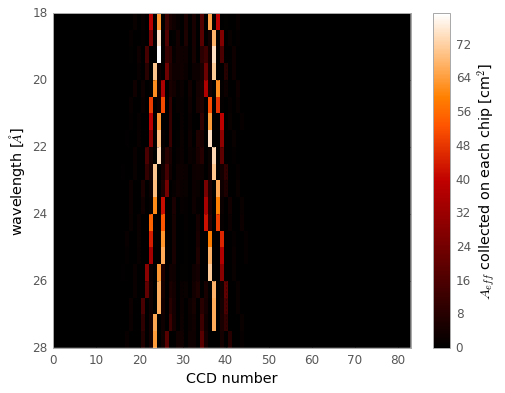

In [27]:
plt.imshow(((n_ccd + n_ccdm) * Ageometric)[20:40, :], interpolation='none',
          extent=(0, 83, wave[40], wave[20]), aspect='auto')
plt.ylabel('wavelength [$\AA{}$]')
plt.xlabel('CCD number')
colbar = plt.colorbar(label='$A_{eff}$ collected on each chip [cm$^2$]')

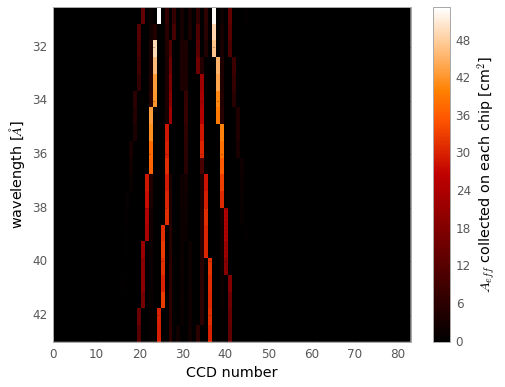

In [28]:
plt.imshow(((n_ccd + n_ccdm) * Ageometric)[50:70, :], interpolation='none',
          extent=(0, 83, wave[70], wave[45]), aspect='auto')
plt.ylabel('wavelength [$\AA{}$]')
plt.xlabel('CCD number')
colbar = plt.colorbar(label='$A_{eff}$ collected on each chip [cm$^2$]')

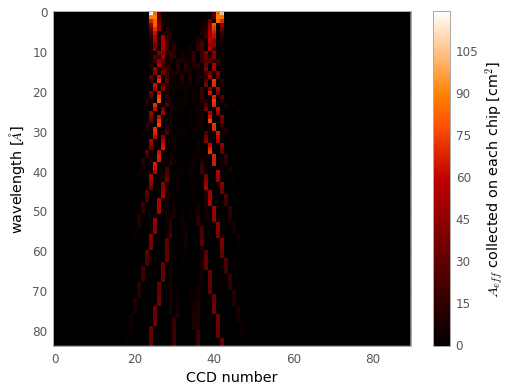

In [29]:
plt.imshow((n_ccd + n_ccdm) * Ageometric, interpolation='none', aspect='auto')
plt.ylabel('wavelength [$\AA{}$]')
plt.xlabel('CCD number')
colbar = plt.colorbar(label='$A_{eff}$ collected on each chip [cm$^2$]')

### Moving CCDs around
In the plot above we looked at which CCDs are most imporant out of a large number of fixed CCDs. However, one could imagine that the effective area actually becomes slighyl better by moving those CCDs just a little, e.g. a few mm to the left of right. This optimization is explored next.

I explore this in two steps, because there are two sets of 8 CCDs in the focal plane. First, I'll move one set of 8 CCDs and then the other.

In [30]:
def Aeff_with_16ccds(theta1, theta2, allrays, id_col='ccd16'):
    '''
    Parameters
    ----------
    theta1, theta2 : float
        position (in radian) of the centers of the first CCD detectors in each group of 8.
    '''
    elem_args = instrum.detccdargs.copy()
    elem_args['id_col'] = id_col
    photonfilter = lambda p: np.isfinite(p['probability']) & (p[id_col] >=0)
    det = marxs.design.RowlandCircleArray(rowland=instrum.rowland_central,
                                          elem_class=marxs.optics.FlatDetector,
                                          elem_args=elem_args, d_element=49.652,
                                          theta=[theta1, theta1 + 0.059, theta2, theta2 + 0.059])
    assert len(det.elements) == 16
    # Check if the id_col in question already exists and if so, set to -1
    for p in allrays:
        if id_col in p.colnames:
            p[id_col] = -1
    return np.array([fractional_aeff(det(p), orders, filterfunc=photonfilter) for p in allrays]), det

In [31]:
# Find the theta angles of the topccd detector distribution.
# We can shift by -1..1 CCD length, but we know that shifts larger than that are alreay ruled out.
autoang = instrum.det.distribute_elements_on_arc()[topccdids]

In [32]:
autoang[0], autoang[8]

(3.133466250615073, 3.2416580000188286)

In [33]:
yshift = np.arange(-0.02, +0.01, 0.001)
aeffs16_1 = [ Aeff_with_16ccds(autoang[0] + x, autoang[8], allrays) for x in  yshift]

In [34]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
for i in range(11,17):
    ae = aeffs16_1[i]
    ax.plot(wave, 
            # Lines lying directly on top of each other are hard to see, so
            # add a little random offset to the y values.
            np.sum(ae[0][:, :-1], axis=1) * Ageometric * 2 + np.random.rand(len(wave))*5,
            label='{0:5.3f}'.format(yshift[i]))
    
ax.plot(wave, np.sum(aeff_16ccd[:, :-1], axis=1) * Ageometric * 2, '0.4', ls='solid', lw=10,
        alpha=.5, label='default')    
ax.legend(loc='upper right')
#ax.set_xlim([22, 31])
ax.set_xlabel('wavelength [$\AA{}$]')
ax.set_ylabel('$A_{eff}$ [cm$^2]$')
#ax.set_ylim([400, 600])
temp = ax.set_title('Moving the first set of CCDs')
mpld3.display(fig)

In [35]:
aeffs16_2 = [ Aeff_with_16ccds(autoang[0], autoang[8] + x, allrays) for x in yshift ]

In [36]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
for i in range(10, len(aeffs16_2)):
    ae = aeffs16_2[i]
    ax.plot(wave, 
            # Lines lying directly on top of each other are hard to see, so
            # add a little random offset to the y values.
            np.sum(ae[0][:, :-1], axis=1) * Ageometric * 2 + np.random.rand(len(wave))*5,
            label='{0:5.3f}'.format(yshift[i]))

ax.plot(wave, np.sum(aeff_16ccd[:, :-1], axis=1) * Ageometric * 2, '0.4', ls='solid', lw=10,
        alpha=.5, label='default') 
ax.legend(loc='upper right')
#ax.set_xlim([22, 31])
ax.set_xlabel('wavelength [$\AA{}$]')
ax.set_ylabel('$A_{eff}$ [cm$^2]$')
#ax.set_ylim([400, 600])
ax.set_title('Moving the second set of CCDs')
mpld3.display(fig)

Looking ot the two plots above, there are two separate effects to be seen:

- Chip gaps: These are unavoidable, but as stated above it is possible that they appear to be absent for some of the simulations because the wavelength grid is too rough rought now. Thus, lines that seem very similar except for a few sudden drops are probably just that - very similar.
- Large structure: The blaze peak is so wide that it is well covered by a set of 8 CCDs. Moving these by just a little (+- half a CCD) only changes the number of rays detected at the edges and that has only a very small effect of the total effective area.

In summary, I can say that optimization of the chip placement on a scale smaller than one chip size (about 50 mm) do not make much of a difference at this point.

## Spectral resolving power

I define the resolving power as:
$R = \frac{\lambda}{\Delta \lambda} = \frac{d_x}{FWMH}$
where $\lambda$ is the wavelength of a spectral line with negligible intrinsic
width, and $\Delta \lambda$ is the observed width of this feature. Since the
detector does not give the wavelength directly, $d_x$ and the $FWHM$ are linear
distances measured along a curved detector that follows the Rowland circle. The $FWMH$ is the full width at
half maximum of the event distribution and $d_x$ is the distance between
the center of a diffracted order and the zeroth order.

In [37]:
from astropy.stats import sigma_clipped_stats

def resolving_power(photons, orders, filterfunc=None, col='proj_x', zeropos=None):
    '''Calculate the resolution in a specific order
    
    If fewer than 20 photons are detected in a single order, this function returns
    nan values.
        
    Parameters
    ----------
    photons : `astropy.table.Table`
        Photon event list
    orders : np.array
        Orders for w
    filterfunc : callable or ``None``
        If not ``None``, a function that takes the photon table and returns an
        index array. This can be used, e.g. filter out photons that hit particular CCDs or
        hot columns.
    col : string
        Column name for the column holding the dispersion coordinate.
    zeropos : float or ``None``
        Value of column `col` where the zeroth order is found. If not given, this is 
        calculated (assuming the zeroth order photons are part of the event list).
        
    Returns
    -------
    prop : np.array
        Probability for a photon in a specific order to be detected.
    '''
    if zeropos is None:
        ind = (photons['order'] == 0)
        if filterfunc is not None:
            ind = ind & filterfunc(photons)
        zeropos, medzeropos, stdzero = sigma_clipped_stats(photons[col][ind])

    pos = np.zeros_like(orders, dtype=float)
    std = np.zeros_like(orders, dtype=float)
    
    for i, o in enumerate(orders):
        ind = (photons['order'] == o)
        if filterfunc is not None:
            ind = ind & filterfunc(photons)

        if ind.sum() > 20:
            meanpos, medianpos, stdpos = sigma_clipped_stats(photons[col][ind])
        else:
            meanpos, stdpos = np.nan, np.nan
        pos[i] = meanpos
        std[i] = stdpos
    res = np.abs(pos - zeropos) / (std * 2.3548)
    return res, pos, std

In [38]:
# Split the two pairs of channels, because they have different zero order positions.
allrays1 = [p[p['facet'] < 2000] for p in allrays]
allrays2 = [p[p['facet'] >= 2000] for p in allrays]

In [39]:
photonfilter = lambda p: np.isfinite(p['probability']) & (p['CCD_ID'] >=0)
res = np.array([resolving_power(p, orders, filterfunc=photonfilter, zeropos=0) for p in allrays1])

In [40]:
outtab = Table(res[:, 0, :], names = ['order_{0}'.format(o) for o in orders])
outtab.add_column(Column(name='wave', data=wave), index=0)
outtab['wave'].unit = u.Angstrom
outtab.write(os.path.join(figureout, 'Resolvingpower.csv'), format='ascii.csv', overwrite=True)

In [143]:
def plot_res(res, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for i, c in zip(np.arange(3, 10), colorcycle):
        ax.plot(wave, res[:, 0, i], label='order {0}'.format(orders[i]))
    ax.legend()
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('resolving power')
    temp = ax.set_xlim([8, 55])
    return ax

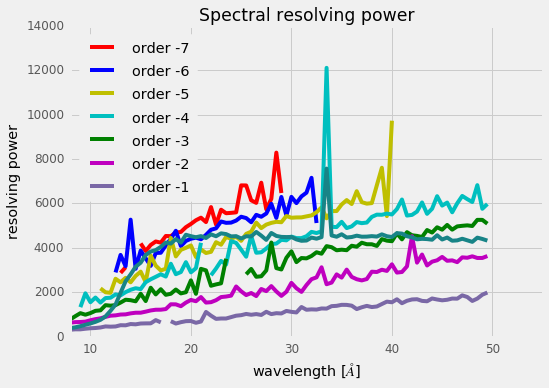

In [147]:
with mpl.style.context('fivethirtyeight'):
    plt.rc('axes', prop_cycle=(cycler('linestyle', ['-', '--', ':']) * 
                               cycler('color', ['r', 'b', 'y', 'c', 'g', 'm', '#7A68A6', '#188487', '#E24A33'])))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = plot_res(res, ax)
    temp = ax.set_title('Spectral resolving power')
    ax.plot(wave, np.ma.average(res_ma[:, 0, :-1], weights=aeff[:, :-1], axis=1))
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('resolving power')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85)
    fig.savefig(os.path.join(figureout, 'respower.png'))
    fig.savefig(os.path.join(figureout, 'respower.pdf'))

Spectral resolving power for individual orders. There can be some wired features in this plot, that are essentially numerirical:

- *gaps*: The resolving power is only calcualted if a certain minimum number of photons is detected in an order. If most photons fall into a chip gap, then values on the curve might be missing.
- *spikes*: If a spectral order falls very close to a chip gap, the distribution of detected photons might seem very small, e.g. if half the order falls into the gap, the FWHM of the distribution of detected photons is only about 1/2 of the real value, leading to an upward spike in resolving power in the plot.

Since I understand where these features are coming from and it's easy to ignore them when looking by eye, I've decided to deal with them in detail later. For now, just ignore them.

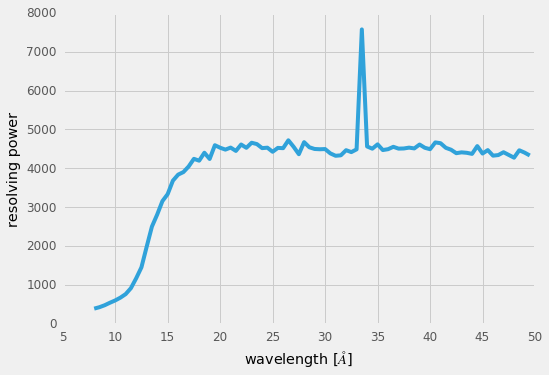

In [145]:
with mpl.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(wave, np.ma.average(res_ma[:, 0, :-1], weights=aeff[:, :-1], axis=1))
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('resolving power')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85)
    fig.savefig(os.path.join(figureout, 'averageres.png'))
    fig.savefig(os.path.join(figureout, 'averageres.pdf'))


## Figure of merit

In [43]:
def combine_figures_of_merit(aeff, res):
    out = np.zeros(aeff.shape)
    for i in range(len(out)):
        res_i = res[:, 0, i]
        sort_res = np.argsort(res_i)
        merits = np.sqrt(res[:, 0, i] * aeff[:, i] * Ageometric * 2)
        out[i] = np.nansum(merits[sort_res[:2]])

    return out

In [44]:
def plot_merrit(aeff, res):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.plot(wave, combine_figures_of_merit(aeff, res), 'k',
    #            label='top 2 orders\nadded')
    for i, c in zip(np.arange(0, 10), colorcycle):
        ax.plot(wave, np.sqrt(res[:, 0, i] * aeff[:, i] * Ageometric * 2),
                label='order {0}'.format(orders[i]))
    ax.legend()
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('Figure of merrit [cm]')
    temp = ax.set_xlim([8, 55])
    return fig, ax

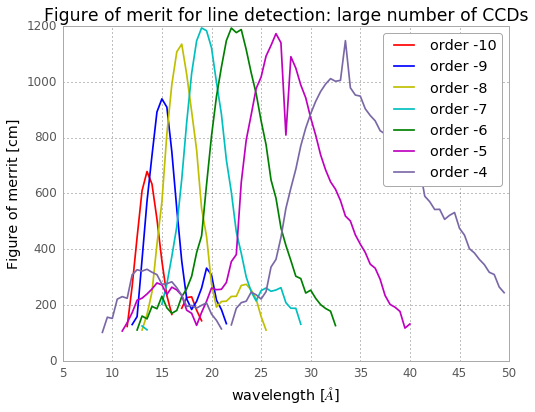

In [45]:
fig, ax = plot_merrit(aeff, res)
ax.set_xlim([5, 50])
temp = ax.set_title('Figure of merit for line detection: large number of CCDs')

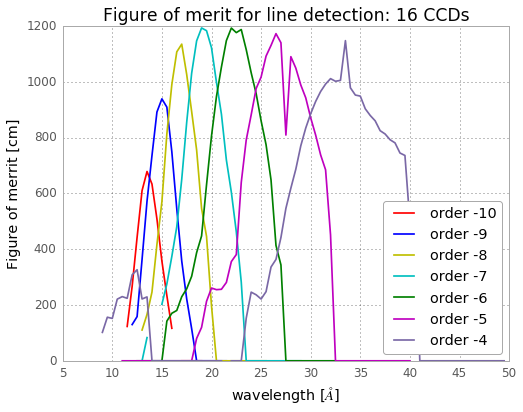

In [46]:
fig, ax = plot_merrit(aeff_16ccd, res)
ax.set_xlim([5, 50])
temp = ax.set_title('Figure of merit for line detection: 16 CCDs')

## An example on the detector
In the next few cells, I will run an example through the ray-trace code and make plots that show the actual detector image that this would produce.
Keep in mind that the current detector model is very simple: There is a uniform CCD contamination and an energy-dependend factor for the quantum efficiency, but otherwise the detector is perfect: No read-out streaks, no pile-up, and no chanrge-transfer inefficiency (all of which are to be expected in real detector) are simulated. Also, this particular simulation does not include any sort of background (astrophysical or instrumental).

For this example, I chose the spectrum of EQ Peg A (an active star) with the parameters from [Liefke et al. (2008)](http://adsabs.harvard.edu/abs/2008A%26A...491..859L). In practice, there is a close companion EQ Peg B and the two spectra will overlap in ARCUS, but for the purposes of this example, EQ Peg A alone will be good enough to represent an emission line spectrum.

The code below reads the input spectrum from table of energy and flux density that I generated with Sherpa (could have used XSPEC or ISIS, too).

In [47]:
EQPegAspec = Table.read('../../inputdata/EQPegA_flux.tbl', format='ascii', names=['energy', 'flux'])
# restrict table to ARCUS energy range
EQPegAspec = EQPegAspec[(EQPegAspec['energy'] > 0.25) & (EQPegAspec['energy'] < 1.5)]

EQPegAcoord = astropy.coordinates.SkyCoord.from_name("EQ Peg A")

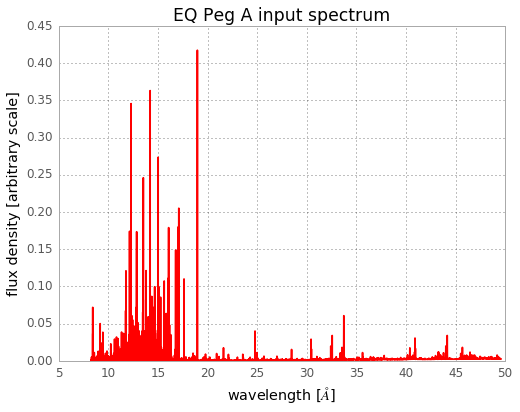

In [48]:
plt.plot((EQPegAspec['energy'] * u.keV).to(u.Angstrom, equivalencies=u.spectral()), EQPegAspec['flux'])
plt.xlabel('wavelength [$\AA{}$]')
plt.ylabel('flux density [arbitrary scale]')
title = plt.title('EQ Peg A input spectrum')

In [49]:
# Simulations runs for a while if we want a large number of photons and thus I run it in an external script.
# Read result for plotting here:
eqpegA = Table.read(os.path.join(dataroot, 'EQPegA100ks.fits'))

In [50]:
topccdids

array([23, 24, 25, 26, 27, 28, 29, 30, 36, 37, 38, 39, 40, 41, 42, 43])

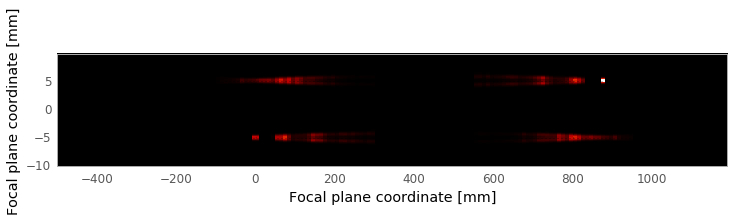

In [51]:
import matplotlib.colors

ind = eqpegA['CCD_ID'] >=0
ind = np.array([c in topccdids for c in eqpegA['CCD_ID']])
fig = plt.figure(figsize=(12,2))
ax = fig.add_subplot(111)
out = ax.hist2d(eqpegA['proj_x'][ind], eqpegA['proj_y'][ind], weights=eqpegA['probability'][ind],
          bins=[np.arange(-500,1200,10.), np.arange(-10, 10, .2)],
          )#norm=matplotlib.colors.LogNorm())
ax.set_xlabel('Focal plane coordinate [mm]')
temp = ax.set_ylabel('Focal plane coordinate [mm]')

Image of the total grating signal detected. The images is shown in focal plane coordinates, projected from the positions where the photons are detected on CCDs that follow the Rowland cirlce. This is **not** the same as the image a flat detector in the focal plane would see. **Note: X and y axis have very different scales!**

The spectrum seems to open up a little bit in the middle because the spectral focus does not coincide with the imaging focus. In other words, the detectors are placed to increase the spectral resolution, at the cost of the sub-optimal width in cross-dipersion direction.

In [52]:
def rect_from_ccd_geometry(geometry):
    bl = geometry('center') + geometry('v_y') + geometry('v_z')
    width = -2. * geometry('v_y')[1]
    height = -2. * geometry('v_z')[2]
    # Scale that to fit in range [0, 1]
    return [(bl[1] + 200.) / 1200., bl[2]/1200.+0.5, width/1200., height/1200.]

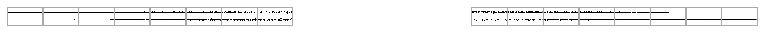

In [53]:
fig = plt.figure(figsize=(12,12))

for i in topccdids:
    rect = rect_from_ccd_geometry(instrum.det.elements[i].geometry)
    #print rect
    ax = fig.add_axes(rect)
    ind = eqpegA['CCD_ID'] == i
    hist, xedges, yedges = np.histogram2d(eqpegA['detpix_y'][ind], 2048-eqpegA['detpix_x'][ind], 
                            weights=eqpegA['probability'][ind],
                            range=[[0,1024], [0,2048]], bins=200
          )
    #mask out 0 as invalid
    hist[hist==0] = np.nan
    im = ax.imshow(hist, aspect='auto', interpolation='none', vmin=1., vmax=200)
    #ax.set_axis_off()
    ax.grid()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
#cax = plt.colorbar(im)
#fig.savefig(os.path.join(figureout, 'EQPegonCCD.pdf'), dpi=300)

Layout of the detectors as seen from the top. In 3-D space the detectors follow the Rowland circle, but they are plotted here as they would be seen from the top. Some dispersed photons fall beyond the boundaries of the chips shown here, but in order to restrict ARCUS to a managable number of chips, choices have to be made and this configuration maximizes the total signal for a fixed number of chips.

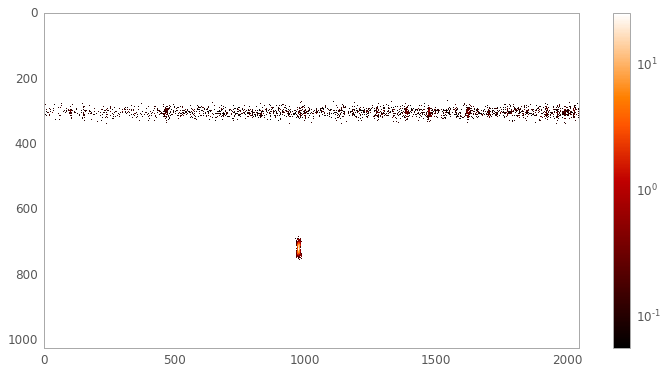

In [104]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)
ind = eqpegA['CCD_ID'] == 24
hist, xedges, yedges = np.histogram2d(eqpegA['detpix_y'][ind], eqpegA['detpix_x'][ind], 
                                weights=eqpegA['probability'][ind],
                            range=[[0,1024], [0,2048]], bins=[1024,2048]
          )
im = ax.imshow(hist, aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm())
ax.grid()
cax = plt.colorbar(im)
#ax.set_axis_off()

fig.savefig(os.path.join(figureout, 'EQPegonCCD24_log.pdf'), dpi=300)
fig.savefig(os.path.join(figureout, 'EQPegonCCD24_log.png'))

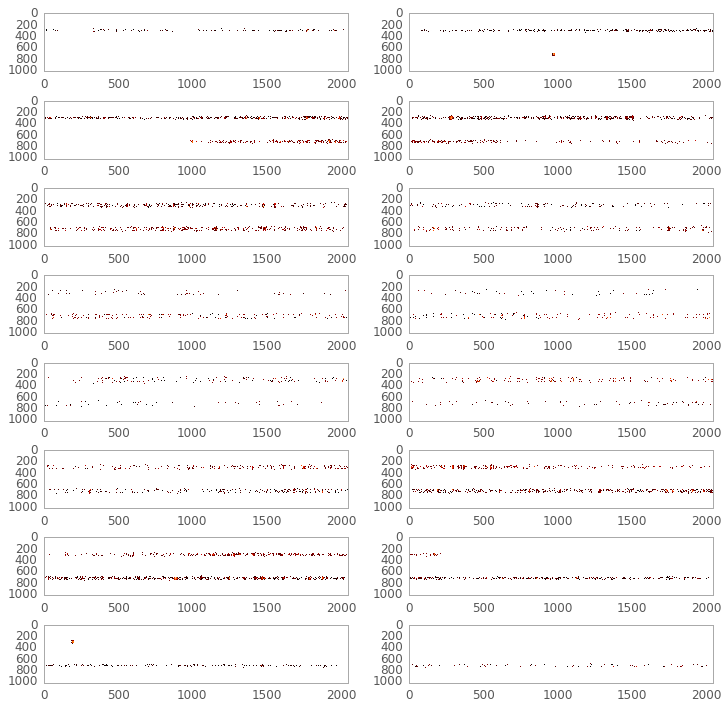

In [55]:
fig = plt.figure(figsize=(12,12))
for j, i in enumerate(topccdids):
    ax = fig.add_subplot(8,2,j + 1)
    ind = eqpegA['CCD_ID'] == i
    hist, xedges, yedges = np.histogram2d(eqpegA['detpix_y'][ind], eqpegA['detpix_x'][ind], 
                                    weights=eqpegA['probability'][ind],
                                range=[[0,1024], [0,2048]], bins=[1024,2048]
              )
    ax.imshow(hist, aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm())
    ax.grid()

This plot show a detector image a single CCD. The image is binned to the size of the actual physical pixels and uses a logarithmic color scale. On the bottom is the spectal trace for one of the pairs of channels, at the top is the zeroth order for the other pair of channels.

## Order sorting
Different orders will overlap spatially on the CCD. We need to make use of the intrinsic energy resolution of the CCD to separate them. Below, I look at two different simulations (EQ Peg with lines and a contionuum source) to determine how good the CCDs have to be to fullfill this task.

In [56]:
# Add a column with a "smeared CCD energy"
eqpegA['PI'] = eqpegA['energy'] * 1000 + np.random.randn(len(eqpegA)) * 65./2.35
ind = eqpegA['energy'] <= 1.
eqpegA['PI'][ind] = eqpegA['energy'][ind] * 1000 + np.random.randn(ind.sum()) * (5 + 8.6 * np.sqrt(3.2 * eqpegA['energy'][ind] + 16.))/2.35
# And, for plotting ad wavelenght column
eqpegA['wave'] = eqpegA['energy'].to(u.Angstrom, equivalencies=u.spectral()).value

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


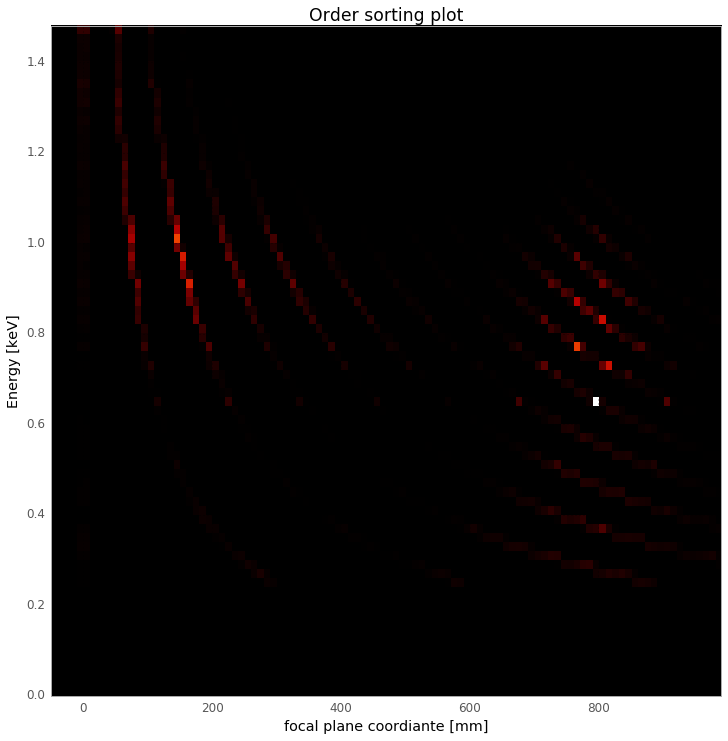

In [57]:
ind = (eqpegA['detpix_y'] < 500)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
out = ax.hist2d(eqpegA['proj_x'][ind], eqpegA['energy'][ind], weights=eqpegA['probability'][ind],
          bins=[np.arange(-50,1000,10.), np.arange(0, 1.5, .02)],
          )#norm=matplotlib.colors.LogNorm())
ax.set_ylabel('Energy [keV]')
ax.set_xlabel('focal plane coordiante [mm]')
temp = ax.set_title('Order sorting plot')

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


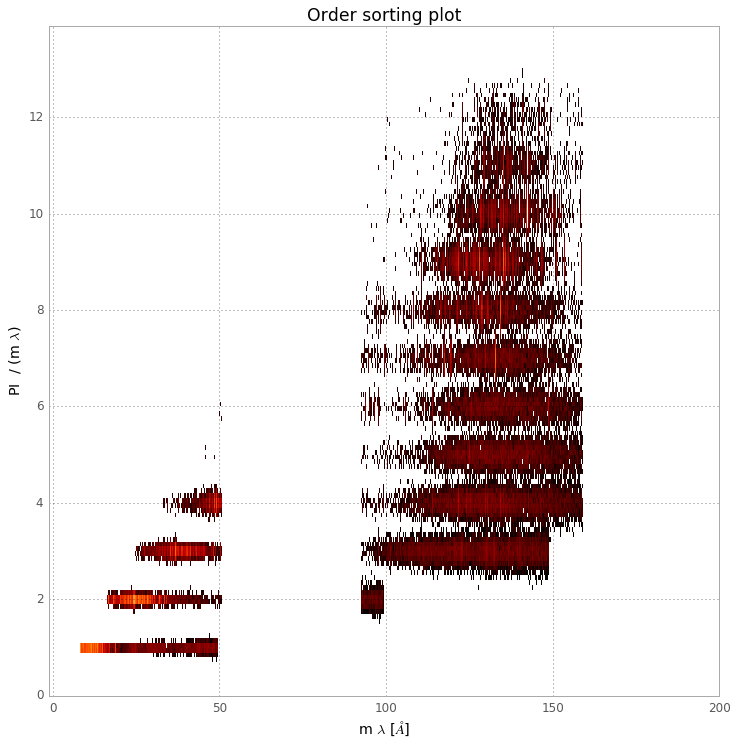

In [58]:
dispersedangle = np.mean(eqpegA['detc1_phi'][ind & (eqpegA['order']==0)]) - eqpegA['detc1_phi']
mlambda = 2000. * np.sin(dispersedangle / 2)

ind = photonfiltertopccds(eqpegA) & (eqpegA['detpix_y'] < 500) & np.isfinite(eqpegA['order'])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
out = ax.hist2d(mlambda[ind],
                eqpegA['PI'][ind] / (mlambda[ind]*u.Angstrom).to(u.eV, equivalencies=u.spectral()), 
    
                weights=eqpegA['probability'][ind],
          bins=[np.arange(-1,  200., .1),np.arange(0, 14, .1)],
          norm=matplotlib.colors.LogNorm())
ax.set_xlabel('m $\lambda$ [$\AA$]')
ax.set_ylabel('PI  / (m $\lambda$)')
temp = ax.set_title('Order sorting plot')

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less


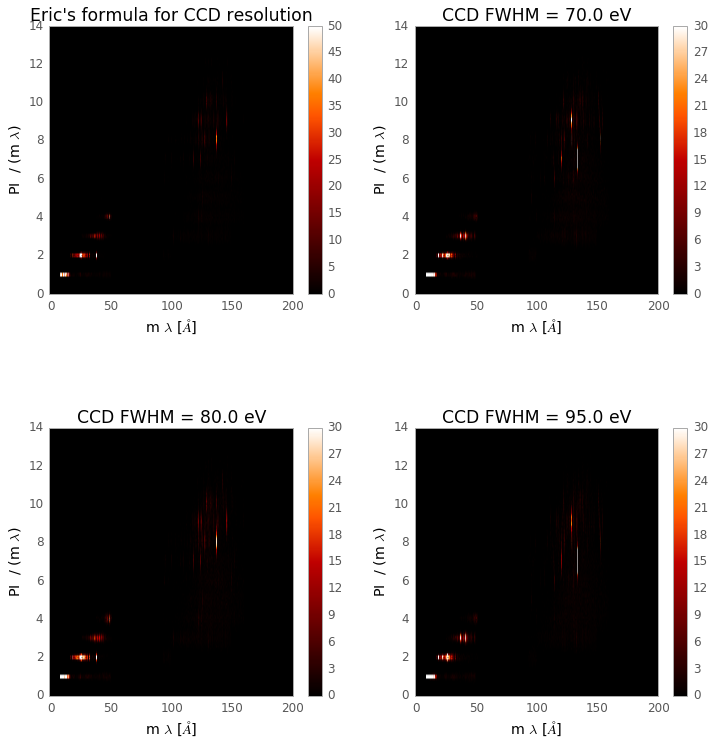

In [59]:
# For plotting add wavelength column
eqpegA['wave'] = eqpegA['energy'].to(u.Angstrom, equivalencies=u.spectral()).value

dispersedangle = np.mean(eqpegA['detc1_phi'][ind & (eqpegA['order']==0)]) - eqpegA['detc1_phi']
mlambda = 2000. * np.sin(dispersedangle / 2)
eqpegA['dispersedangle'] = dispersedangle
eqpegA['mlambda'] = mlambda

ind = photonfiltertopccds(eqpegA) & (eqpegA['detpix_y'] < 500) & np.isfinite(eqpegA['order'])


#Add a column with a "smeared CCD energy"
eqpegA['PI_Eric'] = eqpegA['energy'] * 1000 + np.random.randn(len(eqpegA)) * 65./2.35
ind1 = eqpegA['energy'] > 1.
eqpegA['PI_Eric'][ind1] = eqpegA['energy'][ind1] * 1000 + np.random.randn(ind1.sum()) * (5 + 8.6 * np.sqrt(3.2 * eqpegA['energy'][ind1] + 16.))/2.35

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(2,2,1)
out = np.histogram2d(mlambda[ind],
                     eqpegA['PI_Eric'][ind] / (mlambda[ind]*u.Angstrom).to(u.eV, equivalencies=u.spectral()), 
                     weights=eqpegA['probability'][ind],
                     bins=[np.arange(-1,  200., .1), np.arange(0, 14, .1)])
col = ax.imshow(out[0].T, vmax=50, origin='lower', aspect='auto', extent = (-1, 200, 0, 14))
ax.set_xlabel('m $\lambda$ [$\AA$]')
ax.set_ylabel('PI  / (m $\lambda$)')
ax.set_title("Eric's formula for CCD resolution")
plt.colorbar(col)

for i, s in enumerate([70., 80., 95.]):
    eqpegA['PI'] = eqpegA['energy'] * 1000 + np.random.randn(len(eqpegA)) * s/2.35
    out = np.histogram2d(mlambda[ind],
                    eqpegA['PI'][ind] / (mlambda[ind]*u.Angstrom).to(u.eV, equivalencies=u.spectral()), 
                    weights=eqpegA['probability'][ind],
                     bins=[np.arange(-1,  200., .1),np.arange(0, 14, .1)])

    ax = fig.add_subplot(2, 2, i + 2)
    col = ax.imshow(out[0].T, vmax=30, origin='lower', aspect='auto', extent = (-1, 200, 0, 14))
    ax.set_xlabel('m $\lambda$ [$\AA$]')
    ax.set_ylabel('PI  / (m $\lambda$)')
    ax.set_title("CCD FWHM = {0} eV".format(s))
    plt.colorbar(col)


In [60]:
eqpegA_1 = eqpegA[ind]
eqpegA_1.write(os.path.join(dataroot, 'EQPegA_ordersort.fits'), overwrite=True)

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


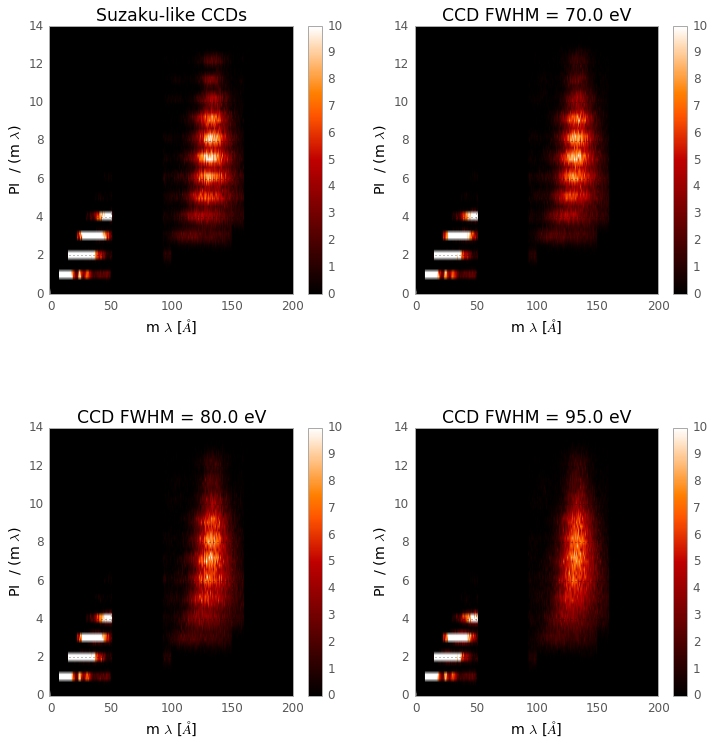

In [105]:
flatspec = Table.read(os.path.join('/melkor/d1/guenther/processing/ARCUS/flatspecjitter000.fits'))
ind = photonfiltertopccds(flatspec) & (flatspec['detpix_y'] < 500) & np.isfinite(flatspec['order'])
# Note this is not EQ Peg, I just don't have time to rename everything
    
# For plotting add wavelength column
flatspec['wave'] = (flatspec['energy']).to(u.Angstrom, equivalencies=u.spectral()).value

dispersedangle = np.mean(flatspec['detc1_phi'][ind & (flatspec['order']==0)]) - flatspec['detc1_phi']
mlambda = 2000. * np.sin(dispersedangle / 2)
flatspec['dispersedangle'] = dispersedangle

#Add a column with a "smeared CCD energy"
flatspec['PI_Eric'] = flatspec['energy'] * 1000 + np.random.randn(len(flatspec)) * 65./2.35
ind1 = flatspec['energy'] > 1.
flatspec['PI_Eric'][ind1] = flatspec['energy'][ind1] * 1000 + np.random.randn(ind1.sum()) * (5 + 8.6 * np.sqrt(3.2 * flatspec['energy'][ind1] + 16.))/2.35

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(2,2,1)
out = np.histogram2d(mlambda[ind],
                     flatspec['PI_Eric'][ind] / (mlambda[ind]*u.Angstrom).to(u.eV, equivalencies=u.spectral()), 
                     weights=flatspec['probability'][ind],
                     bins=[np.arange(-1,  200., .4), np.arange(0, 14, .2)])
col = ax.imshow(out[0].T, vmax=10, origin='lower', aspect='auto', extent = (-1, 200, 0, 14))
ax.set_xlabel('m $\lambda$ [$\AA$]')
ax.set_ylabel('PI  / (m $\lambda$)')
ax.set_title("Suzaku-like CCDs")
plt.colorbar(col)

for i, s in enumerate([70., 80., 95.]):
    flatspec['PI'] = flatspec['energy'] * 1000 + np.random.randn(len(flatspec)) * s/2.35
    out = np.histogram2d(mlambda[ind],
                    flatspec['PI'][ind] / (mlambda[ind]*u.Angstrom).to(u.eV, equivalencies=u.spectral()), 
                    weights=flatspec['probability'][ind],
                     bins=[np.arange(-1,  200., .4),np.arange(0, 14, .2)])

    ax = fig.add_subplot(2, 2, i + 2)
    col = ax.imshow(out[0].T, vmax=10, origin='lower', aspect='auto', extent = (-1, 200, 0, 14))
    ax.set_xlabel('m $\lambda$ [$\AA$]')
    ax.set_ylabel('PI  / (m $\lambda$)')
    ax.set_title("CCD FWHM = {0} eV".format(s))
    plt.colorbar(col)

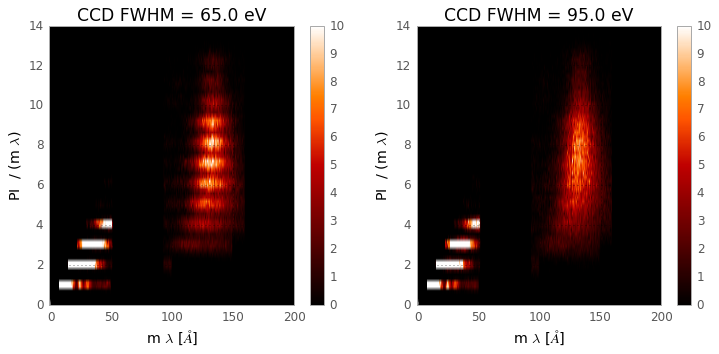

In [111]:
# Similar plot for export
fig = plt.figure(figsize=(11,5))
for i, s in enumerate([65.,  95.]):
    flatspec['PI'] = flatspec['energy'] * 1000 + np.random.randn(len(flatspec)) * s/2.35
    out = np.histogram2d(mlambda[ind],
                    flatspec['PI'][ind] / (mlambda[ind]*u.Angstrom).to(u.eV, equivalencies=u.spectral()), 
                    weights=flatspec['probability'][ind],
                     bins=[np.arange(-1,  200., .4),np.arange(0, 14, .2)])

    ax = fig.add_subplot(1, 2, i + 1)
    col = ax.imshow(out[0].T, vmax=10, origin='lower', aspect='auto', extent = (-1, 200, 0, 14))
    ax.set_xlabel('m $\lambda$ [$\AA$]')
    ax.set_ylabel('PI  / (m $\lambda$)')
    ax.set_title("CCD FWHM = {0} eV".format(s))
    plt.colorbar(col)
    
fig.subplots_adjust(left=0.1, right=0.95)    
fig.savefig(os.path.join(figureout, 'OrderSorting.png'))
fig.savefig(os.path.join(figureout, 'OrderSorting.pdf'))